<a href="https://colab.research.google.com/github/GaganMM/Mywork/blob/main/Fashion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:


# === STEP 1: Import Libraries ===
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Check device (GPU recommended)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 208kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.89MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 3.07MB/s]


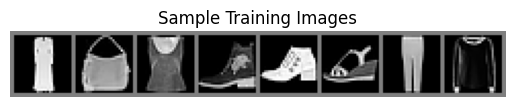

In [2]:
# Transform: convert to tensor + normalize between -1 and 1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load train and test data
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Class names
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

# Show some training images
import torchvision # Import torchvision
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images[:8]))
plt.title("Sample Training Images")
plt.show()

In [3]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = FashionCNN().to(device)
print(model)


FashionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
epochs = 10
train_losses = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # --- Evaluate after each epoch ---
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    test_accuracies.append(acc)
    train_losses.append(running_loss / len(train_loader))

    print(f"Epoch [{epoch+1}/{epochs}] | Loss: {running_loss:.3f} | Test Acc: {acc:.2f}%")

print("Training complete!")


Epoch [1/10] | Loss: 450.757 | Test Acc: 88.06%
Epoch [2/10] | Loss: 291.306 | Test Acc: 89.45%
Epoch [3/10] | Loss: 249.247 | Test Acc: 90.15%
Epoch [4/10] | Loss: 218.689 | Test Acc: 90.66%
Epoch [5/10] | Loss: 197.297 | Test Acc: 91.44%
Epoch [6/10] | Loss: 178.061 | Test Acc: 90.86%
Epoch [7/10] | Loss: 159.452 | Test Acc: 91.37%
Epoch [8/10] | Loss: 143.618 | Test Acc: 91.64%
Epoch [9/10] | Loss: 129.821 | Test Acc: 91.58%


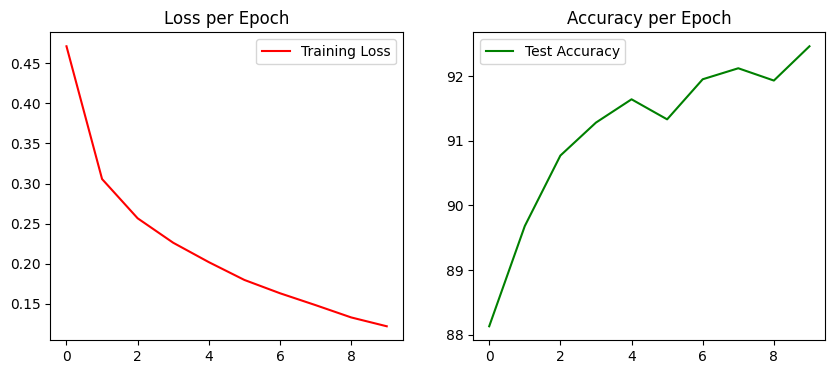

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Training Loss', color='r')
plt.legend(); plt.title('Loss per Epoch')

plt.subplot(1,2,2)
plt.plot(test_accuracies, label='Test Accuracy', color='g')
plt.legend(); plt.title('Accuracy per Epoch')

plt.show()


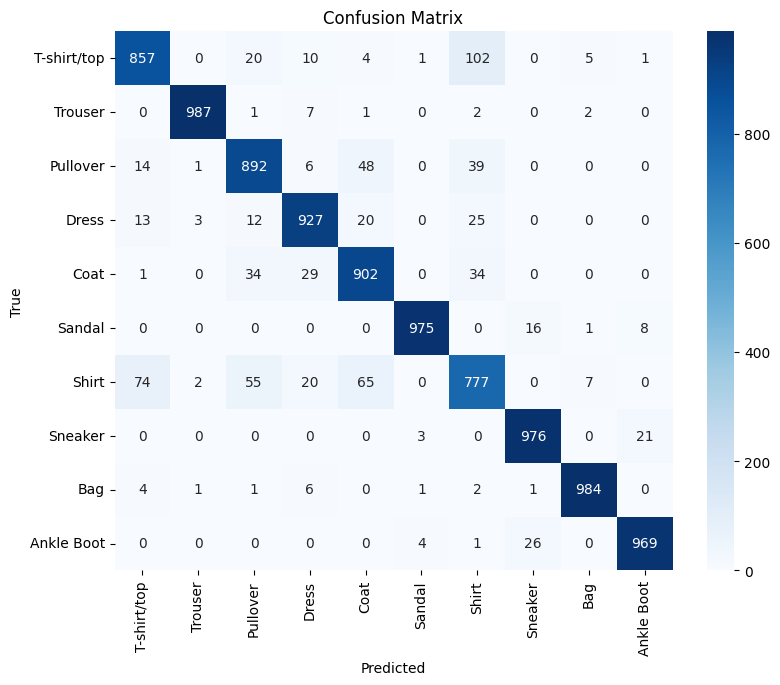

In [ ]:
# Evaluate model
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


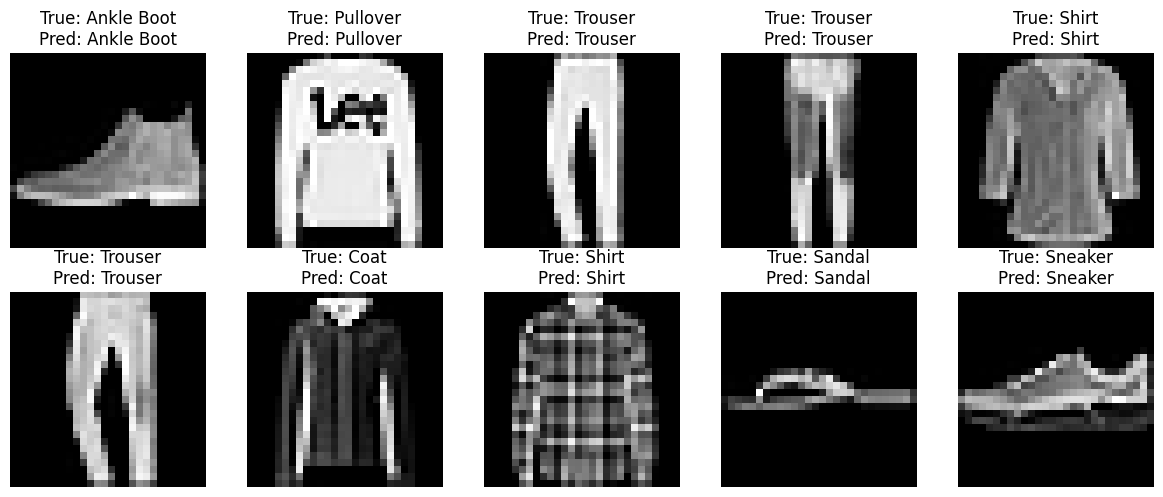

In [ ]:
# Function to predict one image
def predict_image(img):
    img = img.to(device)
    with torch.no_grad():
        output = model(img.unsqueeze(0))
    _, predicted = torch.max(output, 1)
    return classes[predicted.item()]

# Show predictions
dataiter = iter(test_loader)
images, labels = next(dataiter)

fig, axes = plt.subplots(2, 5, figsize=(12,5))
for i, ax in enumerate(axes.flat):
    img = images[i]
    label = classes[labels[i]]
    pred = predict_image(img)
    img = img / 2 + 0.5
    npimg = img.cpu().numpy().squeeze()
    ax.imshow(npimg, cmap='gray')
    ax.set_title(f"True: {label}\nPred: {pred}")
    ax.axis('off')
plt.tight_layout()
plt.show()
